# 📬 Project: SMS Spam Detection using Machine Learning (TF-IDF + Naive Bayes)

**👥 Author: Emmanuel J. Generale**

**📆 Date: June 23, 2025**

**@ Google Collab**

This project builds a machine learning model to detect whether a message is spam or not. It applies NLP techniques like TF-IDF and uses classification algorithms like Naive Bayes and Logistic Regression.



## 🎯 Main Objective

Build a machine learning model that can classify SMS messages as either spam or not spam (also called ham), using natural language processing (NLP) and text classification technique.

**This project will suplement my learnings at Andrew Ng Course about ML Specialization.**

## 📊 Dataset
- Dataset: [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)
- 2 Columns: `label` (spam/ham), `message` (message content)


## 📚 Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


##🧹 Data Loading and Cleaning

- We'll first Load and inspect the DATASET.
- Clean the Data

In [ ]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 📊 Exploratory Data Analysis (EDA)
The goal here is to understand the class distribution, check for imbalances, and explore the data briefly before preprocessing.

/tmp/ipython-input-8-729474371.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts_df, x='label', y='count', palette='viridis')


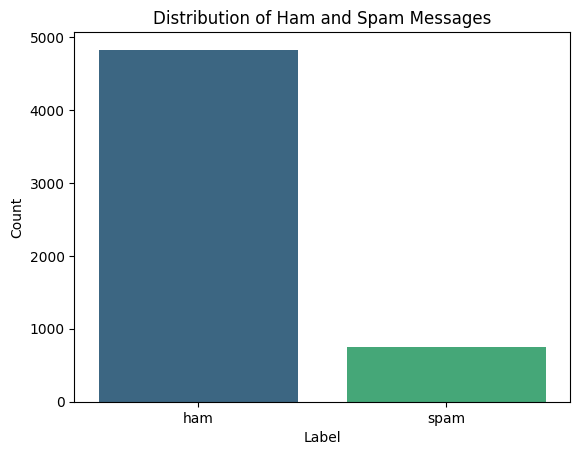

In [ ]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

# Convert to a DataFrame for plotting
label_counts_df = label_counts.reset_index()
label_counts_df.columns = ['label', 'count']

# Plot the barplot
sns.barplot(data=label_counts_df, x='label', y='count', palette='viridis')
plt.title('Distribution of Ham and Spam Messages')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()


## 🧹 Step 3: Text Preprocessing (Cleaning the Messages)

This is one of the most crucial steps in NLP. We'll transform raw SMS text into a cleaner version that's easier for the model to learn from.

**✅ Common Text Preprocessing Steps:**

- Convert text to lowercase

- Remove punctuation

- Remove numbers

- Remove stopwords (e.g., “is”, “the”, “and”, words that don't add much meaning)

**🔍 Example:**

Raw:

"Ate Inday!! You've won $1000 in our lucky draw."

Cleaned:

['Inday', 'won', 'lucky', 'draw']


**Before Using NLTK:**

We need first to install and download resources we need for preprocessing.



**Text Preprocessing Function: clean_text**

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet') # Only needed if we use lemmatization
# Download the specific resource mentioned in the error
nltk.download('punkt_tab')


# Create the stemmer and stopword list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define the cleaning function
def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 3. Tokenize (split into words)
    words = nltk.word_tokenize(text)

    # 4. Remove stopwords and stem each word
    cleaned = [stemmer.stem(word) for word in words if word not in stop_words]

    # 5. Join back to single string
    return ' '.join(cleaned)
# Create the stemmer and stopword list
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define the cleaning function
def clean_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # 3. Tokenize (split into words)
    words = nltk.word_tokenize(text)

    # 4. Remove stopwords and stem each word
    cleaned = [stemmer.stem(word) for word in words if word not in stop_words]

    # 5. Join back to single string
    return ' '.join(cleaned)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


**✅ Apply It to Our Dataset**

In [ ]:
df['cleaned_message'] = df['message'].apply(clean_text)
df[['message', 'cleaned_message']].head()


,message,cleaned_message
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


## ⏭️ Convert Text into Features (TF-IDF)

- We know thst Machines can’t understand text — they need numbers.

- So we’ll convert each cleaned message into a numerical vector using:

**✨ TF-IDF (Term Frequency–Inverse Document Frequency)**

It gives each word a weight:

- High if it appears often in a message

- Low if it appears in many other messages (less useful)**

**Transforming Text into Vector:**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Transform the cleaned messages
X = vectorizer.fit_transform(df['cleaned_message'])

# Target labels (spam = 1, ham = 0)
y = df['label'].map({'ham': 0, 'spam': 1})

**What’s Happening Here:**

- X becomes a sparse matrix with TF-IDF values for each word in each message

- y is your target for training (0 = ham, 1 = spam)



## 🧪 Train-Test Split

**Before training any model, we need to split the dataset into:**

- Training set (to learn from)

- Test set (to evaluate performance on unseen data)



In [ ]:
from sklearn.model_selection import train_test_split

# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


- test_size=0.2: 20% for testing, 80% for training

- random_state=42: sets a seed so results are reproducible



## ✅ Train the Classifier



In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Initialize and train
model = MultinomialNB()
model.fit(X_train, y_train)


MultinomialNB()

## ✅ Model Evaluation

**We’ll use the test set to:**

- Make predictions

- Evaluate how accurate and reliable your model is

### 📊 Evaluation Metrics Explained

| **Metric**         | **Tells Us**                                                                 |
|--------------------|-------------------------------------------------------------------------------|
| **Accuracy**       | Overall percentage of correct predictions                                     |
| **Precision**      | Of predicted spam messages, how many were actually spam                      |
| **Recall**         | Of all actual spam messages, how many were correctly identified              |
| **F1 Score**       | Harmonic mean of precision and recall (good balance when classes are imbalanced) |
| **Confusion Matrix** | Breakdown of correct vs incorrect predictions for both spam and ham         |


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Accuracy : 0.9659192825112107
Precision: 1.0
Recall   : 0.7466666666666667
F1 Score : 0.8549618320610687
Confusion Matrix:
 [[965   0]
 [ 38 112]]


**Let's  plot also:**

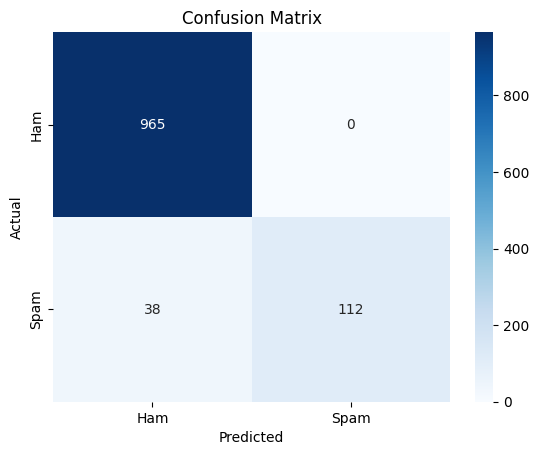

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 📊 Model Evaluation Summary

| **Metric**       | **Value**    | **What It Means**                                                                 |
|------------------|--------------|-----------------------------------------------------------------------------------|
| **Accuracy**     | 0.9659       | Out of all messages, ~96.6% were classified correctly                            |
| **Precision**    | 1.0000       | Every message predicted as spam was actually spam — no false positives           |
| **Recall**       | 0.7467       | Model caught ~75% of all actual spam (missed some)                               |
| **F1 Score**     | 0.8550       | Balanced performance (especially useful for imbalanced data)                     |

### 🔍 Confusion Matrix

|                | **Predicted Ham** | **Predicted Spam** |
|----------------|-------------------|--------------------|
| **Actual Ham** | 965               | 0                  |
| **Actual Spam**| 38                | 112                |


- **High precision is great (no false spam flags).**

- **But if recall is too low, we might miss important spam and that can be a problem.**



## ✅ Predict Custom SMS Message

**Now that the model is trained, let’s test it by feeding it our own SMS**


**We'll go through:**

- Preprocessing the custom message

- Transforming it using the same TfidfVectorizer

- Predicting with our model

- Printing the result: Spam or Ham



**Let's try it first with on custom message to appy the steps."**

In [ ]:
# Test with a custom message
custom_message = "Congratulations! You’ve won a free vacation to Planet Mars. Click here to claim your ticket."

# Step 1: Clean it
cleaned = clean_text(custom_message)

# Step 2: Convert to vector (must be in a list)
vector = vectorizer.transform([cleaned])

# Step 3: Predict
prediction = model.predict(vector)[0]

# Step 4: Output the result
print("Prediction:", "Spam" if prediction == 1 else "Ham")


Prediction: Spam


**And Let's 10 different SMS sample messages with a loop**

In [ ]:
# 10 new custom SMS messages
custom_messages = [
    "Congratulations! You've won a free iPhone. Claim your prize now.",
    "Ley miss na kita sobra, palambing naman po",
    "Free entry in a weekly contest to win $1000. Click here!",
    "Reminder: Your doctor's appointment is scheduled for tomorrow at 10 AM.",
    "URGENT! Your account has been compromised. Respond immediately.",
    "Can you pick me up at the station later?",
    "You've been selected for a chance to get a $500 gift card.",
    "Let's catch up soon! Been a while.",
    "You are a lucky winner! Visit this link to collect your reward.",
    "Don't forget the meeting at 3PM. See you there!"
]

# Loop through messages
for i, msg in enumerate(custom_messages, start=1):
    cleaned = clean_text(msg)
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    result = "Spam" if prediction == 1 else "Ham"

    print(f"{i}. {msg}")
    print(f"   ➤ Prediction: {result}\n")


1. Congratulations! You've won a free iPhone. Claim your prize now.
   ➤ Prediction: Spam

2. Ley miss na kita sobra, palambing naman po
   ➤ Prediction: Ham

3. Free entry in a weekly contest to win $1000. Click here!
   ➤ Prediction: Spam

4. Reminder: Your doctor's appointment is scheduled for tomorrow at 10 AM.
   ➤ Prediction: Ham

5. URGENT! Your account has been compromised. Respond immediately.
   ➤ Prediction: Ham

6. Can you pick me up at the station later?
   ➤ Prediction: Ham

7. You've been selected for a chance to get a $500 gift card.
   ➤ Prediction: Ham

8. Let's catch up soon! Been a while.
   ➤ Prediction: Ham

9. You are a lucky winner! Visit this link to collect your reward.
   ➤ Prediction: Spam

10. Don't forget the meeting at 3PM. See you there!
   ➤ Prediction: Ham



**let's try to play it my using input()**

In [ ]:
# Ask user to enter a message
user_sms = input("Enter your SMS message: ")

# Predict
cleaned = clean_text(user_sms)
vector = vectorizer.transform([cleaned])
prediction = model.predict(vector)[0]

# Output
print("\nPrediction:", "Spam" if prediction == 1 else "Ham")


Enter your SMS message: I love you

Prediction: Ham


**✅ What about an Interactive Widget (Using ipywidgets)**


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create text input widget
sms_input = widgets.Text(
    value='',
    placeholder='Type your SMS here',
    description='SMS:',
    disabled=False,
    layout=widgets.Layout(width='100%')
)

# Create output area
output = widgets.Output()

# Define prediction function
def classify_sms(change):
    output.clear_output()
    cleaned = clean_text(change['new'])
    vector = vectorizer.transform([cleaned])
    prediction = model.predict(vector)[0]
    with output:
        print("\nPrediction:", "Spam" if prediction == 1 else "Ham")

# Trigger classification when text changes
sms_input.observe(classify_sms, names='value')

# Display widget and output
display(sms_input, output)


Text(value='', description='SMS:', layout=Layout(width='100%'), placeholder='Type your SMS here')

Output()

In [45]:
import shutil

# Rename the current notebook (default is always '/content/Untitled0.ipynb' or similar)
shutil.copy('Untitled5.ipynb', '/content/SMS_Spam_Detection_Project.ipynb')


FileNotFoundError: [Errno 2] No such file or directory: 'Untitled5.ipynb'